## pain questionnaire based classification dev

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [3]:
from compare_painquestion import fit_bp, make_data_painquestion
from compare_hyperparams import load_feats, feature_importance, load_modZ, remove_subjs, load_cv, top_mods
from compare_bfl_qsidp import load_qscode, match_question

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


#### load bigflica data

In [4]:
curr_dir = '/well/seymour/users/uhu195/python/extract_npy'
cv_dir = os.path.join(curr_dir, 'cv_results', 'painquestion')

In [5]:
df = load_cv(cv_dir)

   fit_time  score_time  test_accuracy   test_f1  test_roc_auc  bestIC  \
0  7.867734    0.134001       0.510746  0.513208      0.527668      30   
1  7.912590    0.084561       0.514539  0.518193      0.525077      30   
2  7.774593    0.086561       0.488299  0.478401      0.486590      30   
3  7.724113    0.088129       0.509804  0.524831      0.509419      30   
4  2.845258    0.085803       0.532238  0.546569      0.538364      30   

           qsidp  
0           None  
1           None  
2           None  
3           None  
4  ['cognitive']  


In [6]:
df.shape

(1024, 7)

In [7]:
df.iloc[df['test_roc_auc'].argmax()]

fit_time                        3.013279
score_time                      0.089189
test_accuracy                   0.590765
test_f1                         0.590765
test_roc_auc                    0.628504
bestIC                               100
qsidp            ['lifestyle', 'mental']
Name: 42, dtype: object

In [8]:
df.iloc[df['test_accuracy'].argmax()]

fit_time           6.272233
score_time         0.076823
test_accuracy      0.598988
test_f1            0.592021
test_roc_auc       0.623697
bestIC                  100
qsidp            ['mental']
Name: 18, dtype: object

In [9]:
df_g = df.groupby(['bestIC', 'qsidp'])['test_roc_auc', 'test_accuracy'].mean().rename(columns={'test_roc_auc':'auc', 'test_accuracy':'acc'})

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [10]:
df_g.iloc[df_g['auc'].argmax()]

auc    0.600198
acc    0.571770
Name: (50, ['demographic', 'lifestyle', 'mental']), dtype: float64

In [11]:
df_g.iloc[df_g['acc'].argmax()]

auc    0.600198
acc    0.571770
Name: (50, ['demographic', 'lifestyle', 'mental']), dtype: float64

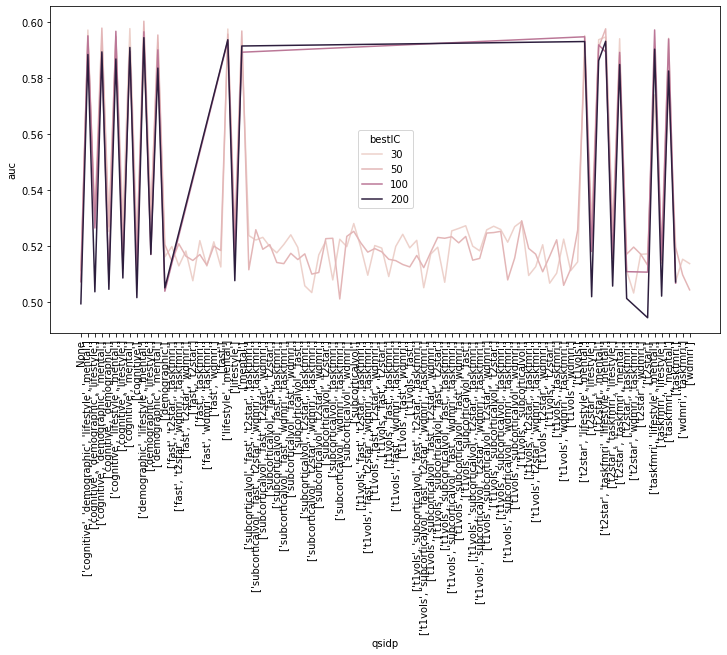

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
_ = sns.lineplot(data=df_g, x='qsidp', y='auc', hue='bestIC', ax=ax)
_ = plt.xticks(rotation=90)

#### check importance

In [13]:
bestIC = 50
qs_ls = ['demographic', 'lifestyle', 'mental']
idp_ls = None

In [62]:
bestIC = 100
qs_ls = ['lifestyle', 'mental']
idp_ls = None

In [63]:
bp = fit_bp(bestIC=bestIC, qs_ls=qs_ls, idp_ls=idp_ls, feat_scaler=True, feat_balance=True, fit_n=10)

/gpfs3/well/seymour/users/uhu195/python/extract_npy/compare_painquestion.py:64: DtypeWarning: Columns (863) have mixed types.Specify dtype option on import or set low_memory=False.
  df_bfl_qsidp = make_data_painquestion(bestIC, qs_ls=qs_ls, idp_ls=idp_ls)


df_qs_imputed_dum shape=(8776, 253)
df_bfl_qsidp shape=(8776, 355)
(8776, 352)


[I 2022-02-17 09:37:34,051] A new study created in memory with name: no-name-bd362019-0390-4354-84b0-dd42007f28b5


(4744, 352) (4744,)


[I 2022-02-17 09:37:38,454] Trial 0 finished with value: 0.5212900505902192 and parameters: {'max_depth': 22, 'n_estimators': 25, 'max_features': 0.8171693175827001, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_samples': 0.6850544747726045}. Best is trial 0 with value: 0.5212900505902192.
[I 2022-02-17 09:38:19,359] Trial 1 finished with value: 0.5465851602023609 and parameters: {'max_depth': 12, 'n_estimators': 175, 'max_features': 0.999338234191129, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_samples': 0.900050934795979}. Best is trial 1 with value: 0.5465851602023609.
[I 2022-02-17 09:38:24,574] Trial 2 finished with value: 0.5564924114671164 and parameters: {'max_depth': 2, 'n_estimators': 175, 'max_features': 0.5693447613394259, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_samples': 0.7817306627793857}. Best is trial 2 with value: 0.5564924114671164.
[I 2022-02-17 09:38:41,746] Trial 3 finished with value: 0.5556492411467117 and parameters: {'max_depth': 18,

In [64]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**bp)

In [65]:
# load bfl
df_bfl_qsidp = make_data_painquestion(bestIC=bestIC, qs_ls=qs_ls, idp_ls=idp_ls)
# retrain params
X_train, y_train, X_valid, y_valid = load_feats(df_bfl_qsidp, bestIC, test_size=0.25, dummies=False,
                              train=True, balance=True, scaler=True)

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (863) have mixed types.Specify dtype option on import or set low_memory=False.
  


df_qs_imputed_dum shape=(8776, 253)
df_bfl_qsidp shape=(8776, 355)
(8776, 352)


In [66]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, max_features=0.46806202833,
                       max_samples=0.6437197567722043, min_samples_leaf=8,
                       min_samples_split=3, n_estimators=200)

In [67]:
preds = clf.predict(X_train)
print(len(preds))
print(balanced_accuracy_score(y_train, preds))
print(sum(y_train==preds)/len(y_train))

4744
0.5925379426644182
0.5925379426644182


In [68]:
preds = clf.predict(X_valid)
print(len(preds))
print(balanced_accuracy_score(y_valid, preds))
print(sum(y_valid==preds)/len(y_valid))

1582
0.5796460176991151
0.5796460176991151


In [69]:
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1])

0.6159192943368905

In [70]:
output_ls = ['label', 'eid', 'bmrc']
tmp = df_bfl_qsidp.drop(columns=output_ls)
feature_names = tmp.columns

In [71]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [72]:
feat_sorted = feat_importances.sort_values(ascending=False)

Text(0, 0.5, 'Mean decrease in impurity')

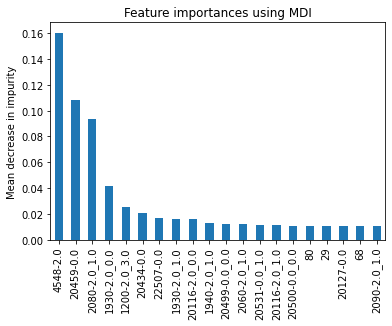

In [73]:
fig, ax = plt.subplots()
feat_sorted.iloc[:20].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [74]:
feats10 = feat_sorted.iloc[:20].index
match_question(feats10)

[array(['Health satisfaction'], dtype=object),
 array(['General happiness with own health'], dtype=object),
 array(['Frequency of tiredness / lethargy in last 2 weeks'], dtype=object),
 array(['Miserableness'], dtype=object),
 array(['Sleeplessness / insomnia'], dtype=object),
 array(['Age at last episode of depression'], dtype=object),
 array(['Age of stopping smoking'], dtype=object),
 array(['Miserableness'], dtype=object),
 array(['Smoking status'], dtype=object),
 array(['Irritability'], dtype=object),
 array(['Ever sought or received professional help for mental distress'],
       dtype=object),
 array(['Frequency of unenthusiasm / disinterest in last 2 weeks'],
       dtype=object),
 array(['Victim of sexual assault'], dtype=object),
 array(['Smoking status'], dtype=object),
 array(['Ever suffered mental distress preventing usual activities'],
       dtype=object),
 array(['Neuroticism score'], dtype=object),
 array(['Seen doctor (GP) for nerves, anxiety, tension or depression']

#### visualising top feature

In [75]:
# data_dir = '/well/tracey/shared/fps-ukb/bigflica_output/output_painquestion_500/Result_IC50/'
data_dir = '/well/tracey/shared/fps-ukb/bigflica_output/output_painquestion_500/Result_IC100/'

In [76]:
def top_mods(data_dir, top_feat, mod_num=3, plot=True):
    """return top modalities given feature importance"""
    mod_contrib = np.load(os.path.join(data_dir, 'mod_contribution.npy')) # mod x feats
#     top_feat = int(feature_importance.index[0].split(' ')[1])
    print(f'top feature: {top_feat}')
    topIC = mod_contrib[:,top_feat]
    # load mod names
    mod_names = pd.read_csv('./sorted_feats.csv')
    plot_mod = mod_names.iloc[topIC.argsort()]
#     print(plot_mod.index.max())
    print('top modalities', plot_mod.iloc[-mod_num:])
    if plot:
        import matplotlib.pyplot as plt
        plt.subplots(figsize=(8,4))
        plt.bar(np.arange(len(topIC)), topIC[topIC.argsort()])
        plot_mod_names = plot_mod['modalities'].values
        plt.xticks(np.arange(len(plot_mod_names)), plot_mod_names, rotation=90)
    return top_feat, plot_mod.index[-mod_num:].values[::-1]

top feature: 80
top modalities                   modalities
22       all_L1_skeletonised
11       all_L2_skeletonised
14       all_FA_skeletonised
9   T1_GM_to_template_GM_mod
27          tractsNormSummed


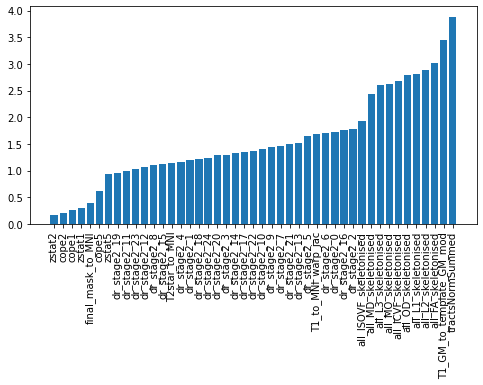

In [78]:
top_feat, mod_ls = top_mods(data_dir, top_feat=80, mod_num=5)

modality 27
(1827095, 100)
modality 9
(228453, 100)
modality 14
(1827095, 100)
modality 11
(1827095, 100)
modality 22
(1827095, 100)


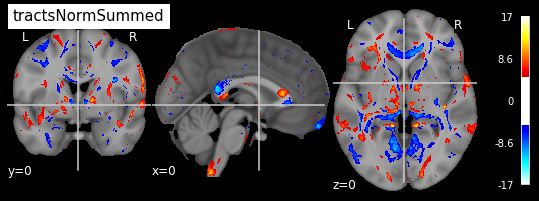

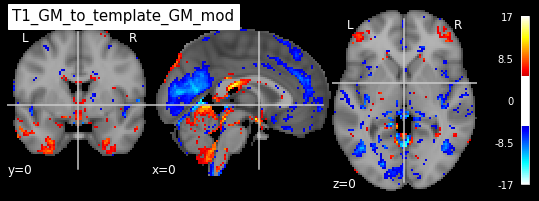

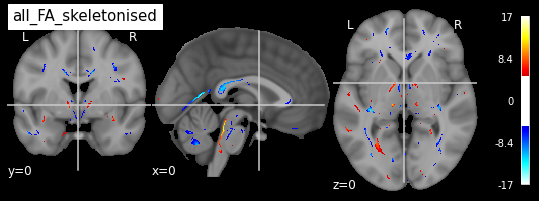

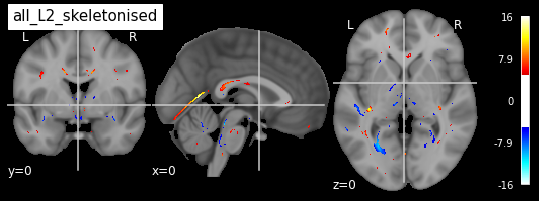

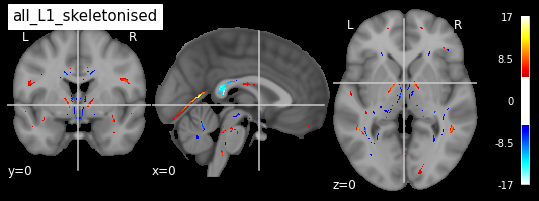

In [80]:
for mod in mod_ls:
    print(f'modality {mod}')
    reshape_z, mask_path = load_modZ(data_dir, modality_num=mod, feature_num=top_feat, plot_threshold=5)

top feature: 29
top modalities                   modalities
9   T1_GM_to_template_GM_mod
34                     cope2
44                     cope1
40                    zstat2
8                     zstat1


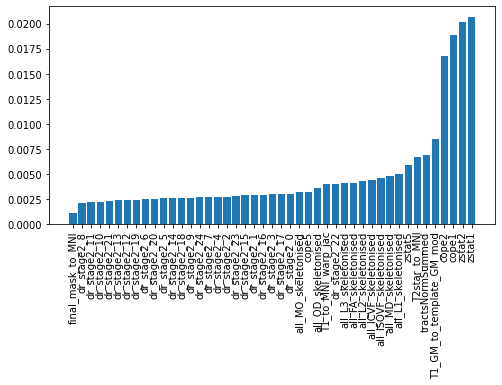

In [81]:
top_feat, mod_ls = top_mods(data_dir, top_feat=29, mod_num=5)

modality 8
(228453, 100)
modality 40
(228453, 100)
modality 44
(228453, 100)
modality 34
(228453, 100)
modality 9
(228453, 100)


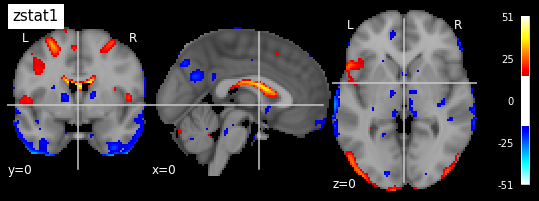

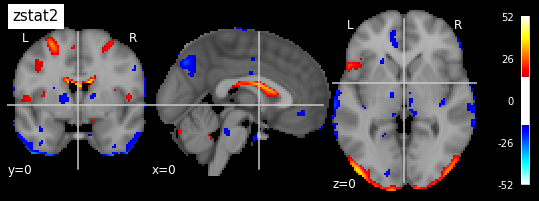

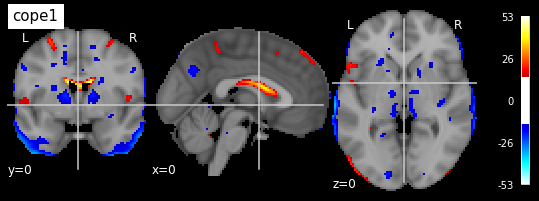

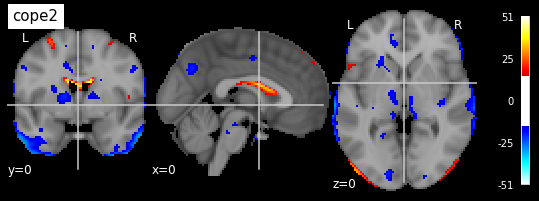

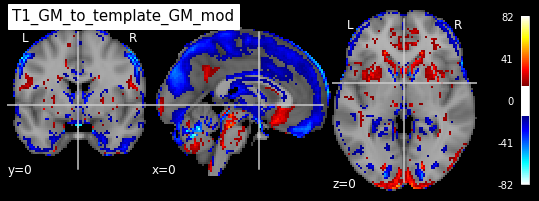

In [85]:
for mod in mod_ls:
    print(f'modality {mod}')
    reshape_z, mask_path = load_modZ(data_dir, modality_num=mod, feature_num=top_feat, plot_threshold=15)